<a href="https://colab.research.google.com/github/nisha1729/Text-Classifier/blob/master/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model

### Load Data 

In [1]:
!pip install Torchtext==0.04

import torch
import torchtext
from torchtext.datasets import text_classification
import os


if not os.path.isdir('./.data'):
    os.mkdir('./.data')

train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS']\
                                (root='./.data', ngrams=2, vocab=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

120000lines [00:11, 10396.31lines/s]
120000lines [00:19, 6184.95lines/s]
7600lines [00:01, 6338.87lines/s]


## Define Model

## Test and Train fucntions


In [64]:
from torch.utils.data import DataLoader



def pad(text):
  # pad each sequence in every mini-batch with zeros
    num_words = DOC_LENGTH
    if len(text) > num_words:
        return text[:num_words]
    else:
        short = num_words - len(text)
        padded = torch.cat([text.to(device), torch.zeros(short).long().to(device)])
        return padded

def generate_batch(data_batch):
    label = torch.tensor([entry[0] for entry in data_batch])
    text = [pad(entry[1]) for entry in data_batch]
    offsets = [0] + [len(entry) for entry in text]  

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.stack(text).permute(1,0)
    return text, offsets, label


def train(train_data):
    train_loss = 0
    total_acc = 0

    data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
  
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()        
        
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)

        loss = criterion(output, cls)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        total_acc += (output.argmax(1) == cls).sum().item() 

    scheduler.step()

    total_train_loss = train_loss/len(train_data)
    total_train_acc = total_acc/len(train_data)

    return total_train_loss, total_train_acc 


def test(test_data):
    test_acc = 0
    test_loss = 0
    data = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
    
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            
            loss = criterion(output, cls)
            test_loss += loss.item()
            
            test_acc += (output.argmax(1) == cls).sum().item()

            total_test_loss = test_loss/len(test_data)
            total_test_acc = test_acc/len(test_data)

    return total_test_loss, total_test_acc

data_batch is batch of 16 sequances in the form` [(label,text)]`

## Train the model

In [ ]:
from torch import nn


HIDDEN_DIM = 256
OUTPUT_DIM = 4
VOCAB_SIZE = len(train_dataset.get_vocab())
NUM_CLASS = len(train_dataset.get_labels())
lr =  2e-5
BATCH_SIZE = 16
EMBEDDING_DIM = 32
DOC_LENGTH = 500 # length of each sequence in a mini_batch
criterion = nn.CrossEntropyLoss()


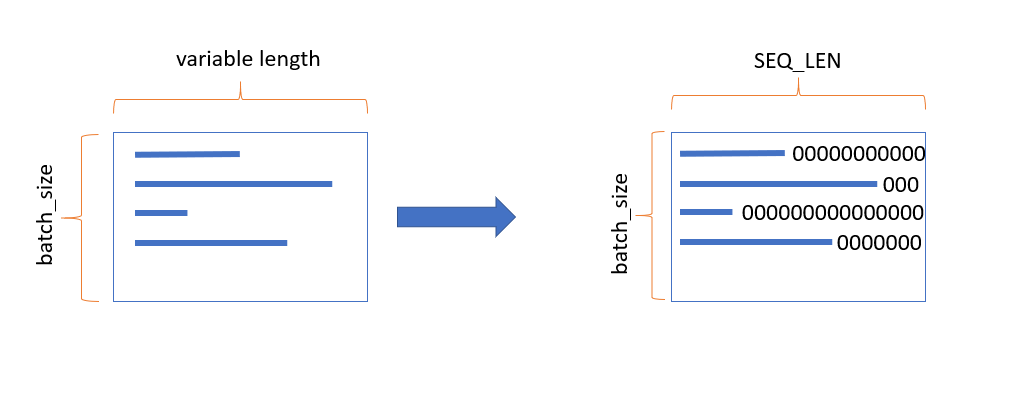

In [71]:
from torch import nn


class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size):
        
        super().__init__()

        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, text, offset):
        embedded = self.embedding(text.to(device))
        last_output, (last_hidden, last_cell) = self.lstm(embedded)
        output = self.fc(last_hidden[-1])
        return output 

In [ ]:
import time
from torch.utils.data.dataset import random_split
from torch import nn
from tqdm.autonotebook import tqdm


N_EPOCHS = 13
TRAIN_RATIO = 0.9
valid_loss = float('inf')

model = LSTM(EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASS, VOCAB_SIZE).to(device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters() )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_size = int(len(train_dataset)*TRAIN_RATIO)
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

for epoch in tqdm(range(N_EPOCHS)):
    start_time = time.time()
    train_loss, train_acc = train(train_set)
    valid_loss, valid_acc = test(val_set)
    secs = int(time.time() - start_time)
    
    print('Epoch: %d' %(epoch + 1), " | time : .2f" %(secs/60))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    torch.save(model.state_dict(), f"model_{epoch+5}")

for the test function, load each model for each epoch and generate its results on the test dataset, this way we will findout when to stop.





In [ ]:
for i in range(13):
    torch.cuda.empty_cache() 
    model = LSTM(32, HIDDEN_DIM, 4, VOCAB_SIZE).to(device)
    model.load_state_dict(torch.load(f"model_{i}"))
    print(f'Epoch{i+1} test results........using model{i+1}')
    test_loss, test_acc = test(test_dataset)
    print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')